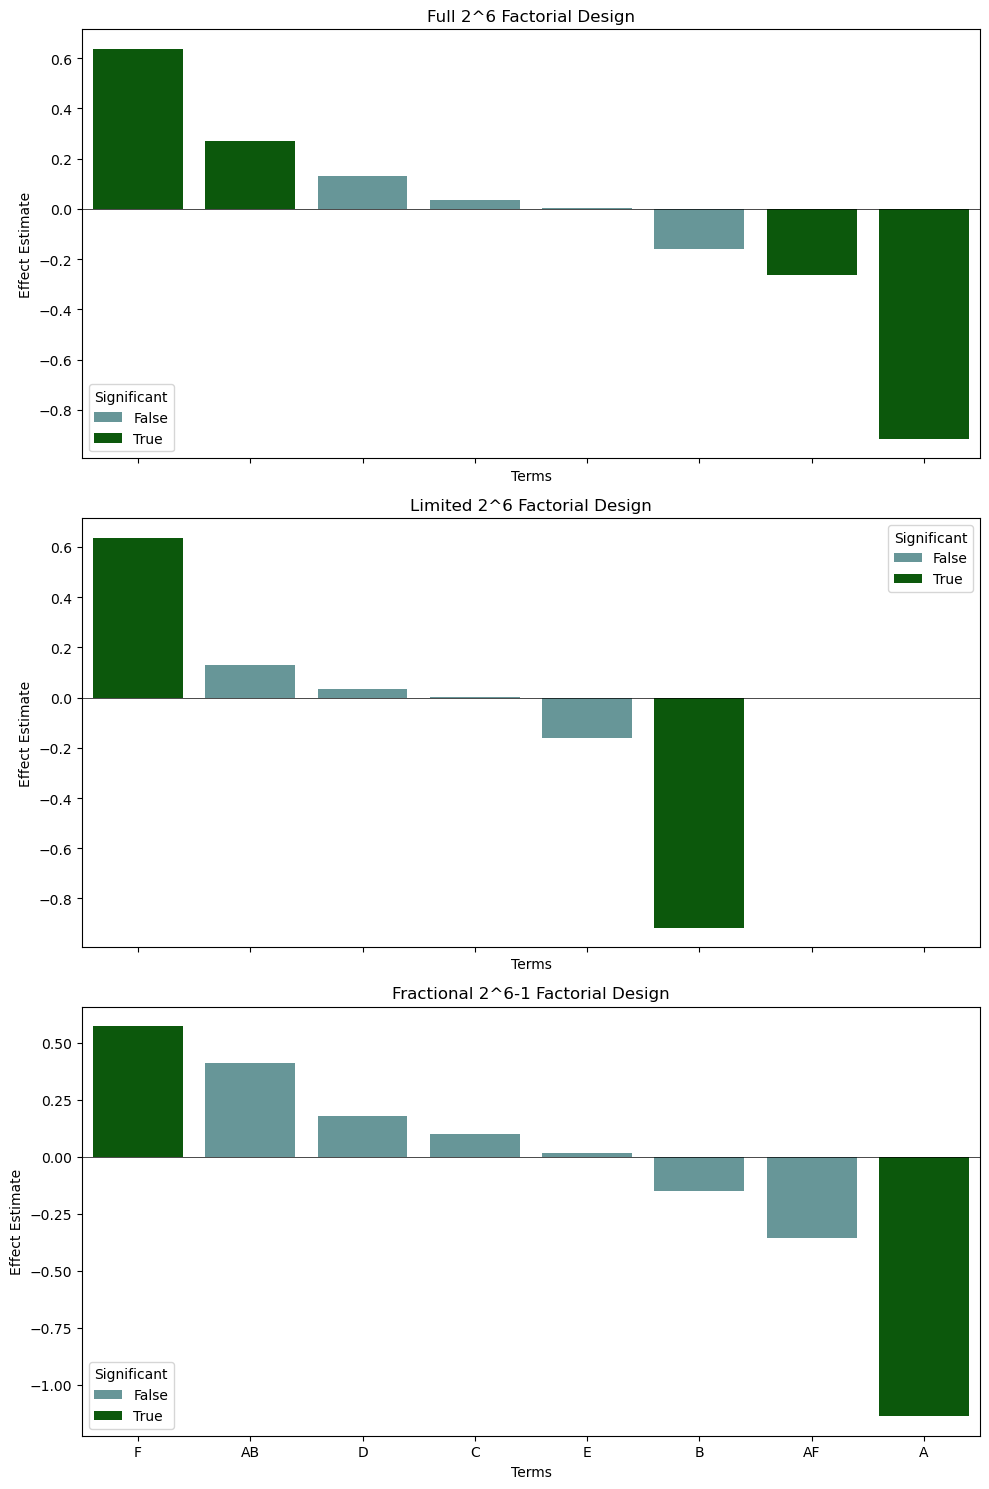

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product, combinations

# Define factors and number of levels
factors = ['A', 'B', 'C', 'D', 'E', 'F']
n_levels = 2
n_runs = n_levels**len(factors)  # Number of experiments for a full factorial design

# Create the full factorial design
design = np.array(list(product(*[[-1, 1]]*len(factors))))
df = pd.DataFrame(design, columns=factors)

# Simulate data using the model from the paper
np.random.seed(0)  # Seed for reproducibility
effects = np.array([-0.5, 0.15, 0.65])  # Effects for A, C, F respectively
interaction_effects = {'AB': 0.2, 'AF': -0.5}  # Interaction effects

# Calculate the response 'y'
df['y'] = 1.5 + effects[0]*df['A'] + effects[1]*df['C'] + effects[2]*df['F']
for interaction, effect in interaction_effects.items():
    factor1, factor2 = interaction
    df['y'] += effect * df[factor1] * df[factor2]
df['y'] += np.random.normal(0, 1, size=n_runs)  # Add random noise

# Function to fit the model and get effects and significance
def fit_model_and_get_effects(design_df, include_interactions=False):
    # Prepare data for regression
    X = design_df[factors]
    if include_interactions:
        # Include only two-factor interactions that are in interaction_effects
        for interaction in interaction_effects.keys():
            factor1, factor2 = interaction
            X[interaction] = design_df[factor1] * design_df[factor2]
    X = sm.add_constant(X)  # Add constant term
    y = design_df['y']

    # Fit linear regression model
    model = sm.OLS(y, X).fit()

    # Get estimated effects and their significance
    effects = model.params[1:]  # Exclude the constant term
    significances = model.pvalues[1:] < 0.05  # Significance cut-off of 0.05
    return effects, significances

# Fit models for each scenario
full_effects, full_significances = fit_model_and_get_effects(df, include_interactions=True)
limited_effects, limited_significances = fit_model_and_get_effects(df)
# For the fractional design, take a random half of the data
fractional_df = df.sample(frac=0.5, random_state=1)
fractional_effects, fractional_significances = fit_model_and_get_effects(fractional_df, include_interactions=True)

# Function to plot the effects
def plot_effects(effects, significances, title, ax):
    effects_df = pd.DataFrame({'Effect': effects, 'Significant': significances})
    effects_df.sort_values('Effect', inplace=True, ascending=False)
    sns.barplot(x=effects_df.index, y='Effect', hue='Significant', data=effects_df, ax=ax, dodge=False, palette=['cadetblue', 'darkgreen'])
    ax.set_title(title)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Terms')
    ax.set_ylabel('Effect Estimate')

# Create the plots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
plot_effects(full_effects, full_significances, 'Full 2^6 Factorial Design', axes[0])
plot_effects(limited_effects, limited_significances, 'Limited 2^6 Factorial Design', axes[1])
plot_effects(fractional_effects, fractional_significances, 'Fractional 2^6-1 Factorial Design', axes[2])
plt.tight_layout()
plt.show()